<h1>Chapter 13 Applications of the Ising Model<h1>

<h2>13.1 Physical Interpretations<h2>

<h2>13.2 Phase Transitions<h2>

<h3>13.2.1 Model<h3>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sy
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
def arrayPlot(array,vmin=0,vmax=None):
    #plt.style.use('_mpl-gallery-nogrid')
    fig, ax = plt.subplots()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(array,cmap='Greys',vmin=vmin,vmax=vmax)
    plt.show()

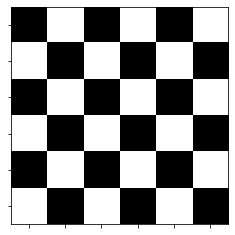

In [3]:
nSize = 6
checkerboardConfig = np.array([[(-1)**(row+col) for row in range(nSize)] for col in range(nSize)])
arrayPlot(checkerboardConfig,-1,1)

In [4]:
def MCstepPBC(kT,J,B,config):
    newConfig = config.copy()
    row,col = np.random.randint(0,len(config),2)
    Estart = config[row,col]*B
    if row>0: # Up
        Estart += J*config[row-1,col]*config[row,col] # Interior
    else:
        Estart += J*config[len(config)-1,col]*config[row,col] # Periodic boundary conditions
    if row<len(config)-1: # Down
        Estart += J*config[row+1,col]*config[row,col] # Interior
    else:
        Estart += J*config[0,col]*config[row,col] # Periodic boundary conditions
    if col>0: # Left
        Estart += J*config[row,col-1]*config[row,col] # Interior
    else:
        Estart += J*config[row,len(config)-1]*config[row,col] # Periodic boundary conditions
    if col<len(config)-1: # right
        Estart += J*config[row,col+1]*config[row,col] # Interior
    else:
        Estart += J*config[row,0]*config[row,col] # Periodic boundary conditions
    Eend = -Estart
    if Eend<Estart or np.random.random()<=np.exp(-(Eend-Estart)/kT): # Did the energy decrease or it randomly increases in energy?
        newConfig[row,col]*=-1
    return newConfig # Return the potentially altered array

In [5]:
def energyIsing2DPBC(config, J, B):
    energyB = 0
    energyJ = 0
    for row in range(len(config)):
        for col in range(len(config)):
            energyB += B*config[row,col]
            if row>0: # Up
                energyJ += J*config[row-1,col]*config[row,col] # Interior
            else:
                energyJ += J*config[len(config)-1,col]*config[row,col] # Periodic boundary conditions
            if row<len(config)-1: # Down
                energyJ += J*config[row+1,col]*config[row,col] # Interior
            else:
                energyJ += J*config[0,col]*config[row,col] # Periodic boundary conditions
            if col>0: # Left
                energyJ += J*config[row,col-1]*config[row,col] # Interior
            else:
                energyJ += J*config[row,len(config)-1]*config[row,col] # Periodic boundary conditions
            if col<len(config)-1: # right
                energyJ += J*config[row,col+1]*config[row,col] # Interior
            else:
                energyJ += J*config[row,0]*config[row,col] # Periodic boundary conditions
    return energyB+(energyJ/2) # Remove double counting and return final result

In [6]:
def netMagnetization(config):
    return np.sum(config)
def netMagnetizationPerSpin(config):
    return netMagnetization(config)/len(config)**2

In [7]:
def runMC(kT, J, B, nEquil, nDataCol, sampleInterval, config, MCstepFunction, energyFunction):
    Esamples = []
    Msamples = []
    newConfig = config.copy()
    for i in range(nEquil):
        newConfig = MCstepFunction(kT, J, B, newConfig)
    for i in range(nDataCol):
        newConfig = MCstepFunction(kT, J, B, newConfig)
        if i%sampleInterval == 0:
            Esamples.append(energyFunction(newConfig,J,B))
            Msamples.append(abs(netMagnetizationPerSpin(newConfig)))
    Esamples = np.array(Esamples)
    Msamples = np.array(Msamples)
    return [Esamples.mean()/len(config)**2, # Energy per spin
           Esamples.var(ddof=1)/(len(config)**2*kT**2), # Heat Capacity
           Msamples.mean(), # Net magnetization per spin
           newConfig] # The Final configuration

In [8]:
J, B = -1, 0 # Ferromagnetic, no external magnetic field
config = checkerboardConfig # 6x6 checkerboard lattice

EvsT, CvsT, MvsT = [], [], [] # Empty lists to store E, Cv, M

for kT in np.arange(4,1,-0.1):
    results = runMC(kT,J,B,10**4,2*10**5,10**3,config,MCstepPBC,energyIsing2DPBC)
    
    EvsT.append([kT,results[0]])
    CvsT.append([kT,results[1]])
    MvsT.append([kT,results[2]])
    config = results[3]

<h3>13.2.2 Results<h3>

In [9]:
EvsT = np.array(EvsT)
CvsT = np.array(CvsT)
MvsT = np.array(MvsT)

(0.0, 1.0)

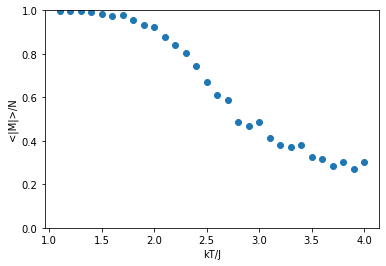

In [10]:
fig = plt.figure()
plt.scatter(MvsT[:,0],MvsT[:,1])
plt.xlabel('kT/J')
plt.ylabel('<|M|>/N')
plt.ylim([0, 1])

Text(0, 0.5, '<|E|>/N')

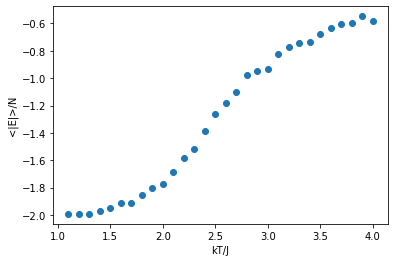

In [11]:
fig = plt.figure()
plt.scatter(EvsT[:,0],EvsT[:,1])
plt.xlabel('kT/J')
plt.ylabel('<|E|>/N')

Text(0, 0.5, 'C/kN')

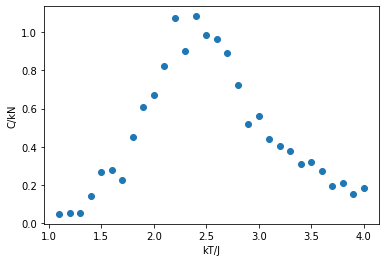

In [12]:
fig = plt.figure()
plt.scatter(CvsT[:,0],CvsT[:,1])
plt.xlabel('kT/J')
plt.ylabel('C/kN')

<h3>13.2.3 Big Picture<h3>

<h2>13.3 Solubility and Miscibility<h2>

<h2>13.3.1 Model<h2>

In [13]:
def countTotallySolvated(config, soluteType):
  totalSolvated = 0
  for row in range(len(config)):
    for col in range(len(config)):
      nnSameType = 0
      if config[row,col] == soluteType:
        if row>0 and config[row-1,col] == soluteType:
          nnSameType+=1
        if row<len(config)-1 and config[row+1,col] == soluteType:
          nnSameType+=1
        if col>0 and config[row,col-1] == soluteType:
          nnSameType+=1
        if col<len(config)-1 and config[row,col+1] == soluteType:
          nnSameType+=1
        if nnSameType == 0:
          totalSolvated+=1
  return totalSolvated

In [14]:
def var(a):
  return ((a-a.mean())**2).sum()/len(a)

def runMCv2(kT, J, B, nEquil, nDataCol, sampleInterval, config, MCstepFunction, energyFunction):
  Esamples, Msamples, NsolvSamples = [], [], []
  newConfig = config.copy()
  for i in range(nEquil):
    newConfig = MCstepFunction(kT,J,B,newConfig)
  for i in range(nDataCol):
    newConfig = MCstepFunction(kT,J,B,newConfig)
    if i % sampleInterval == 0:
      Esamples.append(energyFunction(newConfig,J,B))
      Msamples.append(abs(netMagnetizationPerSpin(newConfig)))
      NsolvSamples.append(countTotallySolvated(newConfig,-1))

  Esamples = np.array(Esamples)
  Msamples = np.array(Msamples)
  NsolvSamples = np.array(NsolvSamples)
  return [Esamples.mean()/len(config)**2, # Energy per spin
          Esamples.var(ddof=1)/((len(config)**2)*(kT**2)), # Heat capacity
          Msamples.mean(), # Net magnetization per spin
          NsolvSamples.mean(), # Numbger of totally solvated -1 sites
          newConfig] # The Final Configuration

In [15]:
def energyIsing2D(config,J,B):
    energyB,energyJ = 0,0 # Initializes local variables
    for row in range(len(config)): # Loop over rows
        for col in range(len(config)): # Simultaneously loop over columns
            energyB += B*config[row,col]
            if row>0: # Up
                energyJ += J*config[row-1,col]*config[row,col]
            if row<len(config)-1: # Down
                energyJ += J*config[row+1,col]*config[row,col]
            if col>0: # Left
                energyJ += J*config[row,col-1]*config[row,col]
            if col<len(config)-1: # Right
                energyJ += J*config[row,col+1]*config[row,col]
    return energyB + energyJ/2 # Removes double counting 

In [16]:
def MCstepConstN(kT,J,B,config):
    newConfig=config.copy()
    configDidChange=False
    rowA,colA,rowB,colB=np.random.randint(0,len(config),4)
    
    spinA = config[rowA,colA]
    spinB = config[rowB,colB]
    
    if spinA != spinB: # Only do MC procedure if something charged
        newConfig[rowA,colA] = spinB # First, interchange the spins
        newConfig[rowB,colB] = spinA
        Estart = energyIsing2D(config,J,B) # Get configuration energies
        Eend = energyIsing2D(newConfig,J,B)
        if Eend<Estart or np.random.random()<np.exp(-(Eend-Estart)/kT): # Did the energy decrease or it randomly increases in energy?           
            configDidChange = True
    if configDidChange: # Did the configuration change uring this process
        return newConfig # configDidChange==True, so return the new spin config
    return config # Otherwise, return the original spin configuration

<h3>13.3.2 Advanced Mathematica techniques: Timing[] is everything<h3>

In [17]:
import time

def timing(func, *args):
  startTime = time.time()
  result = func(*args)
  endTime = time.time()

  return [endTime-startTime,result]

In [18]:
J, B, kT = -1, 0, 4
config = np.array([[1]*10]*10) # Create a 10x10 array of spins
config[4,:] = -1 # Create a stripe down the middle
timing(runMCv2, kT, J, B, 10000, 200000, 1000, config, MCstepConstN, energyIsing2D)

[26.443671464920044,
 [-1.2478,
  0.028964572864321605,
  0.8,
  4.615,
  array([[ 1,  1,  1, -1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1, -1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1, -1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [-1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1, -1, -1,  1,  1],
         [ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1]])]]

In [19]:
def localEnergyIsing2D(config, J, B, row, col):
    energyB = 0
    energyJ = 0

    energyB += B*config[row,col]

    if row>0: # Up
        energyJ += J*config[row-1,col]*config[row,col]
    if row<len(config)-1: # Down
        energyJ += J*config[row+1,col]*config[row,col]
    if col>0: # Left
        energyJ += J*config[row,col-1]*config[row,col]
    if col<len(config)-1: # Right
        energyJ += J*config[row,col+1]*config[row,col]

    return energyB + energyJ # Note: no double counting to remove
  

In [20]:
def MCstepConstNv2(kT, J, B, config):
  newConfig=config.copy()
  configDidChange=False
  rowA,colA,rowB,colB=np.random.randint(0,len(config),4)

  spinA = config[rowA, colA] # Spin values at each position
  spinB = config[rowB, colB]

  if spinA != spinB: # Only do MC procedure if something changed
    newConfig[rowA, colA] = spinB # First, interchange the spins
    newConfig[rowB, colB] = spinA

    # Revised: Replace former Estart and Eend evaluation
    if (rowA-rowB)**2 + (colA-colB)**2 < 5: # Are spins nearby
      # True: too close to separate the evaluations
      Estart = energyIsing2D(config,J,B)
      Eend = energyIsing2D(newConfig,J,B)
    else:
      # False: far enough apart to make two separate evaluations
      Estart = localEnergyIsing2D(config, J, B, rowA, colA) + localEnergyIsing2D(config, J, B, rowB, colB)
      Eend = localEnergyIsing2D(newConfig, J, B, rowA, colA) + localEnergyIsing2D(newConfig, J, B, rowB, colB)
    
    # MC accept/reject is the same as before
    if Eend<Estart or np.random.random()<=np.exp(-(Eend-Estart)/kT): # Did the energy decrease or it randomly increases in energy?
      configDidChange = True

  if configDidChange: # Did the configuration change uring this process
    return newConfig # configDidChange==True, so return the new spin config
  return config # Otherwise, return the original spin configuration

In [21]:
timing(runMCv2, kT, J, B, 10**4, 2*10**5, 10**3, config, MCstepConstNv2, energyIsing2D)

[6.522568225860596,
 [-1.2361,
  0.026700942211055276,
  0.8,
  4.9,
  array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1, -1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1, -1, -1,  1,  1,  1,  1],
         [-1,  1,  1,  1,  1,  1,  1,  1,  1, -1],
         [-1,  1,  1,  1,  1,  1,  1,  1, -1,  1],
         [ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1, -1,  1,  1, -1,  1,  1,  1]])]]

In [22]:
def energyIsing2D(config, J, B):
  energyB = 0
  energyJ = 0

  for row in range(len(config)): # loop over rows and columns
    for col in range(len(config[0])):
      energyB += B*config[row,col]
      if row>0: # Up
        energyJ += J*config[row-1,col]*config[row,col]
      if row<len(config)-1: # Down
        energyJ += J*config[row+1,col]*config[row,col]
      if col>0: # Left
        energyJ += J*config[row,col-1]*config[row,col]
      if col<len(config[0])-1: # Right
        energyJ += J*config[row,col+1]*config[row,col]

  return energyB + (energyJ/2) # Remove double counting

In [23]:
def min(a,b):
  if a < b:
    return a
  return b

def max(a,b):
  if a > b:
    return a
  return b

In [24]:
def MCstepConstNv3(kT, J, B, config):
  newConfig=config.copy()
  configDidChange=False
  rowA,colA,rowB,colB=np.random.randint(0,len(config),4)

  spinA = config[rowA, colA] # Spin values at each position
  spinB = config[rowB, colB]

  if spinA != spinB: # Only do MC procedure if something changed
    newConfig[rowA, colA] = spinB # First, interchange the spins
    newConfig[rowB, colB] = spinA

    # Replace former Estart and Eend evaluation
    if (rowA-rowB)**2 + (colA-colB)**2 < 5: # Are spins nearby
      # True: too close to separate the evaluations

      # Begin revision
      minRow = max(min(rowA,rowB)-1 , 0)
      maxRow = min(max(rowA,rowB)+1, len(config)-1)
      minCol = max(min(colA,colB)-1 , 0)
      maxCol = min(max(colA,colB)+1, len(config[0])-1)
      Estart = energyIsing2D(config[minRow:maxRow+1,minCol:maxCol+1], J, B)
      Eend = energyIsing2D(newConfig[minRow:maxRow+1,minCol:maxCol+1], J, B)
      # End revision
    else:
      # False: far enough apart to make two separate evaluations
      Estart = localEnergyIsing2D(config, J, B, rowA, colA) + localEnergyIsing2D(config, J, B, rowB, colB)
      Eend = localEnergyIsing2D(newConfig, J, B, rowA, colA) + localEnergyIsing2D(newConfig, J, B, rowB, colB)
    
    # MC accept/reject is the same as before
    if Eend<Estart or np.random.random()<=np.exp(-(Eend-Estart)/kT): # Did the energy decrease or it randomly increases in energy?
      configDidChange = True

  if configDidChange: # Did the configuration change uring this process
    return newConfig # configDidChange==True, so return the new spin config
  return config # Otherwise, return the original spin configuration

In [25]:
timing(runMCv2, kT, J, B, 10**4, 2*10**5, 10**3, config, MCstepConstNv3, energyIsing2D)

[4.80715799331665,
 [-1.2403,
  0.03254968592964824,
  0.8,
  4.825,
  array([[ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
         [ 1,  1,  1, -1, -1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1],
         [ 1,  1,  1,  1,  1, -1, -1, -1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1, -1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
         [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])]]

<h3>13.3.3 Results<h3>

In [26]:
J, B = -1, 0
config = np.array([[1]*10]*10) # Create a 10x10 array of spins
config[4,:] = -1 # Create a stripe down the middle
E, C, M, Solv, T = [],[],[],[],[]

for kT in np.arange(4,10**-6,-0.1):
  results = runMCv2(kT, J, B, 10000, 200000, 1000, config, MCstepConstNv3, energyIsing2D)

  E.append(results[0])
  C.append(results[1])
  M.append(results[2])
  Solv.append(results[3]/10) # Fraction solvated
  T.append(kT)

Text(0, 0.5, '<|M|>/N')

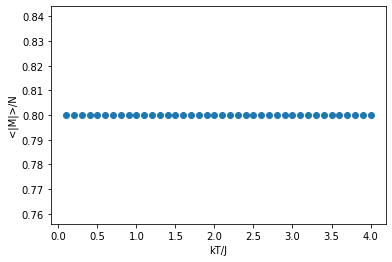

In [27]:
plt.scatter(T,M)
plt.xlabel('kT/J')
plt.ylabel('<|M|>/N')

Text(0, 0.5, '<E>/N')

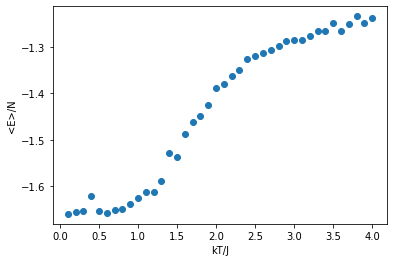

In [28]:
plt.scatter(T,E)
plt.xlabel('kT/J')
plt.ylabel('<E>/N')

Text(0, 0.5, 'Fraction totally solvated')

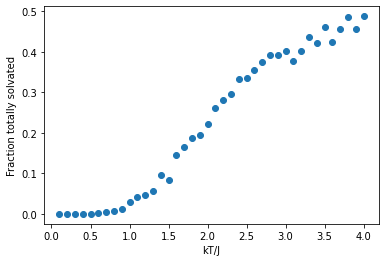

In [29]:
plt.scatter(T,Solv)
plt.xlabel('kT/J')
plt.ylabel('Fraction totally solvated')

Text(0, 0.5, 'C/kN')

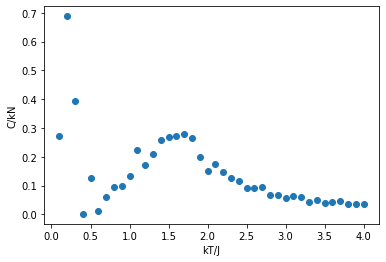

In [30]:
plt.scatter(T,C)
plt.xlabel('kT/J')
plt.ylabel('C/kN')

<h2>13.4 Gas Adsorption Isotherms<h2>

<h2>13.4.1 Model<h2>

<h2>13.4.2 Widom insertion method<h2>

In [31]:
def insertionAverage(kT, Eint, Eads, config, nTrials):
  sum = 0
  for i in range(nTrials): # Loop over trials
    row, col = np.random.randint(0,len(config),2)
    if config[row,col] == 0: # Can only add particle to unoccupied site
      newConfig = config.copy()
      newConfig[row,col] = 1
      sum += np.exp(-localEnergyIsing2D(newConfig, Eint, Eads, row, col)/kT)
  return sum/nTrials # Return insertion average, B

In [52]:
def runWidomInsertion(kT, Eint, Eads, nEquil, nSwap, nInsertionTrials, nRepeats, config, MCstepFunction, insertionFunction):
  newConfig = config.copy()
  sum = 0
  # First, equilibriate
  for i in range(nEquil):
    newConfig = MCstepFunction(kT, Eint, Eads, newConfig)
  for i in range(nRepeats):
    for j in range(nSwap):
      newConfig = MCstepFunction(kT, Eint, Eads, newConfig)
    sum += insertionFunction(kT, Eint, Eads, newConfig, nInsertionTrials)
  return sum/nRepeats

<h3>13.4.3 Results<h3>

In [53]:
def generateConfig(occupancy, length):
  
  config = []
  for i in range(length):
    row = []
    for j in range(length):
      if i*length+j < occupancy*length**2:
        row.append(1)
      else:
        row.append(0)
    config.append(row)
  return np.array(config)

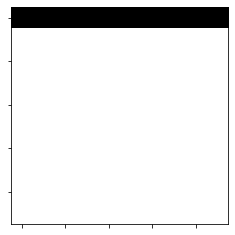

In [54]:
arrayPlot(generateConfig(0.1, 10))

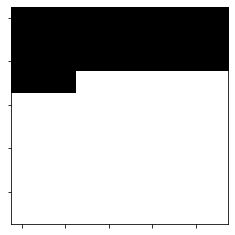

In [55]:
arrayPlot(generateConfig(0.33, 10))

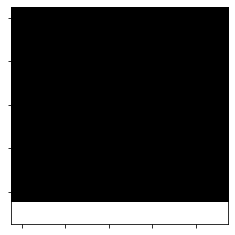

In [56]:
arrayPlot(generateConfig(0.9, 10))

In [61]:
kT, adsorptionEnergy, interactionEnergy = 0.5, -1, 0
data = []
boxLength = 10

for occupancy in np.arange(0.01,0.91001,0.1): # Loop over occupancy fraction
  config = generateConfig(occupancy, boxLength)
  data.append([occupancy/runWidomInsertion(kT, interactionEnergy, adsorptionEnergy, 
               10000, 1000, 200, 200, config, MCstepConstNv3, insertionAverage),
              occupancy])

Text(0, 0.5, 'theta')

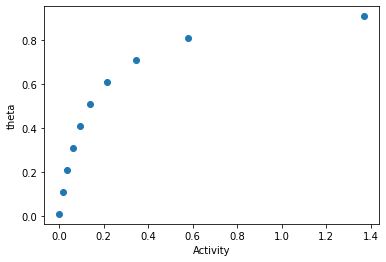

In [62]:
data = np.array(data)
xVals = data[:,0]
yVals = data[:,1]
g1 = plt.scatter(xVals,yVals)
plt.xlabel('Activity')
plt.ylabel('theta')

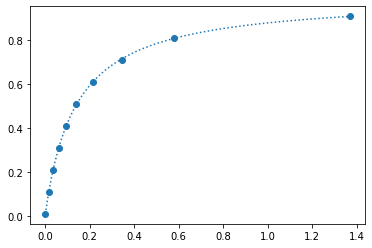

In [68]:
from scipy.optimize import curve_fit

def langmuirIsotherm(K,P):
  return K*P/(1+K*P)

popt, pcov = curve_fit(langmuirIsotherm, xVals, yVals)

xValsFit = np.linspace(np.min(xVals),np.max(xVals),100)
plt.plot(xValsFit, langmuirIsotherm(xValsFit, *popt), ":")

plt.scatter(xVals,yVals)